Install the tools

In [1]:
#!pip install torch dm_control numpy==1.23.5 matplotlib gym==0.25.2 wandb

https://www.datacamp.com/tutorial/proximal-policy-optimization

Import the packages in Python

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torch.distributions as distributions
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.distributions import Normal, TransformedDistribution
from torch.distributions.transforms import TanhTransform
import numpy as np
import gym
import os
from dm_control import suite
from dm_control.suite.wrappers import pixels
from auxiliares import converter_cinza, training_device
device = training_device()
import random
import wandb


mps


Loading autoencoder for deepmind control

In [3]:
def reparameterize(z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

# Encoder com mais camadas convolucionais para maior poder representacional
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim, in_channels=1,hidden_units = 32):  
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_units, kernel_size=4, stride=2, padding=1)   # -> (batch, 64, 42, 42)
        self.conv2 = nn.Conv2d(hidden_units, hidden_units*2, kernel_size=4, stride=2, padding=1)            # -> (batch, 128, 21, 21)
        self.conv3 = nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=4, stride=2, padding=1)           # -> (batch, 256, 10, 10)
        
        self.flatten_dim = hidden_units*4 * 10 * 10  # Tamanho do vetor achatado após as convoluções
        self.fc_mean = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_log_var = nn.Linear(self.flatten_dim, latent_dim)
    
    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = f.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Achata para (batch, flatten_dim)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim, out_channels=1, hidden_units=32):  # Alterei o out_channels para 3 para imagens RGB
        super(CNNDecoder, self).__init__()
        self.hidden_units = hidden_units
        self.fc = nn.Linear(latent_dim, hidden_units*4 * 10 * 10)  # Mapeia o vetor latente para uma representação plana
        self.deconv1 = nn.ConvTranspose2d(hidden_units*4, hidden_units*2, kernel_size=4, stride=2, padding=1, output_padding=1)  
        self.deconv2 = nn.ConvTranspose2d(hidden_units*2, hidden_units, kernel_size=4, stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(hidden_units, out_channels, kernel_size=4, stride=2, padding=1, output_padding=0)
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), (self.hidden_units)*4, 10, 10)  # Reorganiza para (batch, 256, 10, 10)
        x = f.relu(self.deconv1(x))
        x = f.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))  # Sigmoid para valores entre 0 e 1
        return x


# VAE combinando o Encoder e o Decoder com CNNs mais complexas
class VAE(nn.Module):
    def __init__(self, latent_dim, in_channels=1, hidden_units=32):
        super(VAE, self).__init__()
        self.encoder = CNNEncoder(latent_dim, in_channels,hidden_units=hidden_units)
        self.decoder = CNNDecoder(latent_dim, out_channels=in_channels, hidden_units=hidden_units)
    
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = reparameterize(z_mean, z_log_var)
        recon = self.decoder(z)
        return recon, z_mean, z_log_var



In [4]:
# 1. Defina os mesmos parâmetros usados no treinamento
latent_dim = 128  # Substitua pelo valor usado originalmente
in_channels = 1   # Substitua pelo valor usado originalmente
hidden_units = 128 # Substitua pelo valor usado originalmente

# 2. Instancie o modelo e otimizador (igual ao do treinamento)
model = VAE(latent_dim=latent_dim, in_channels=in_channels, hidden_units=hidden_units).to(device)
optimizer = torch.optim.Adam(model.parameters())  # Ou o otimizador que você usou

# 3. Caminho para o checkpoint
checkpoint_dir = "autoencoder/dgx_treino3-lat128_lr0.0001_h128/checkpoint_dgx_treino3-lat128_lr0.0001_h128_epoch570.pt" #TODO
epoch_to_load = 570                           # Epoch que deseja carregar

checkpoint_path = os.path.join(checkpoint_dir)

# 4. Carregue o checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    
    # Carregue os estados
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Outras informações do checkpoint
    loaded_epoch = checkpoint['epoch']
    loaded_loss = checkpoint['loss']
    loaded_test_loss = checkpoint['test_loss']
    
    print(f"Checkpoint carregado com sucesso (Epoch {loaded_epoch})")
    print(f"Loss de treino no checkpoint: {loaded_loss:.4f}")
    print(f"Loss de teste no checkpoint: {loaded_test_loss:.4f}")
    
    # Coloque o modelo em modo de avaliação
    model.eval()
else:
    print(f"Erro: Arquivo de checkpoint não encontrado em {checkpoint_path}")

encoder = model.encoder
print(next(model.parameters()).device)


Checkpoint carregado com sucesso (Epoch 570)
Loss de treino no checkpoint: 9.4301
Loss de teste no checkpoint: 9.6787
mps:0


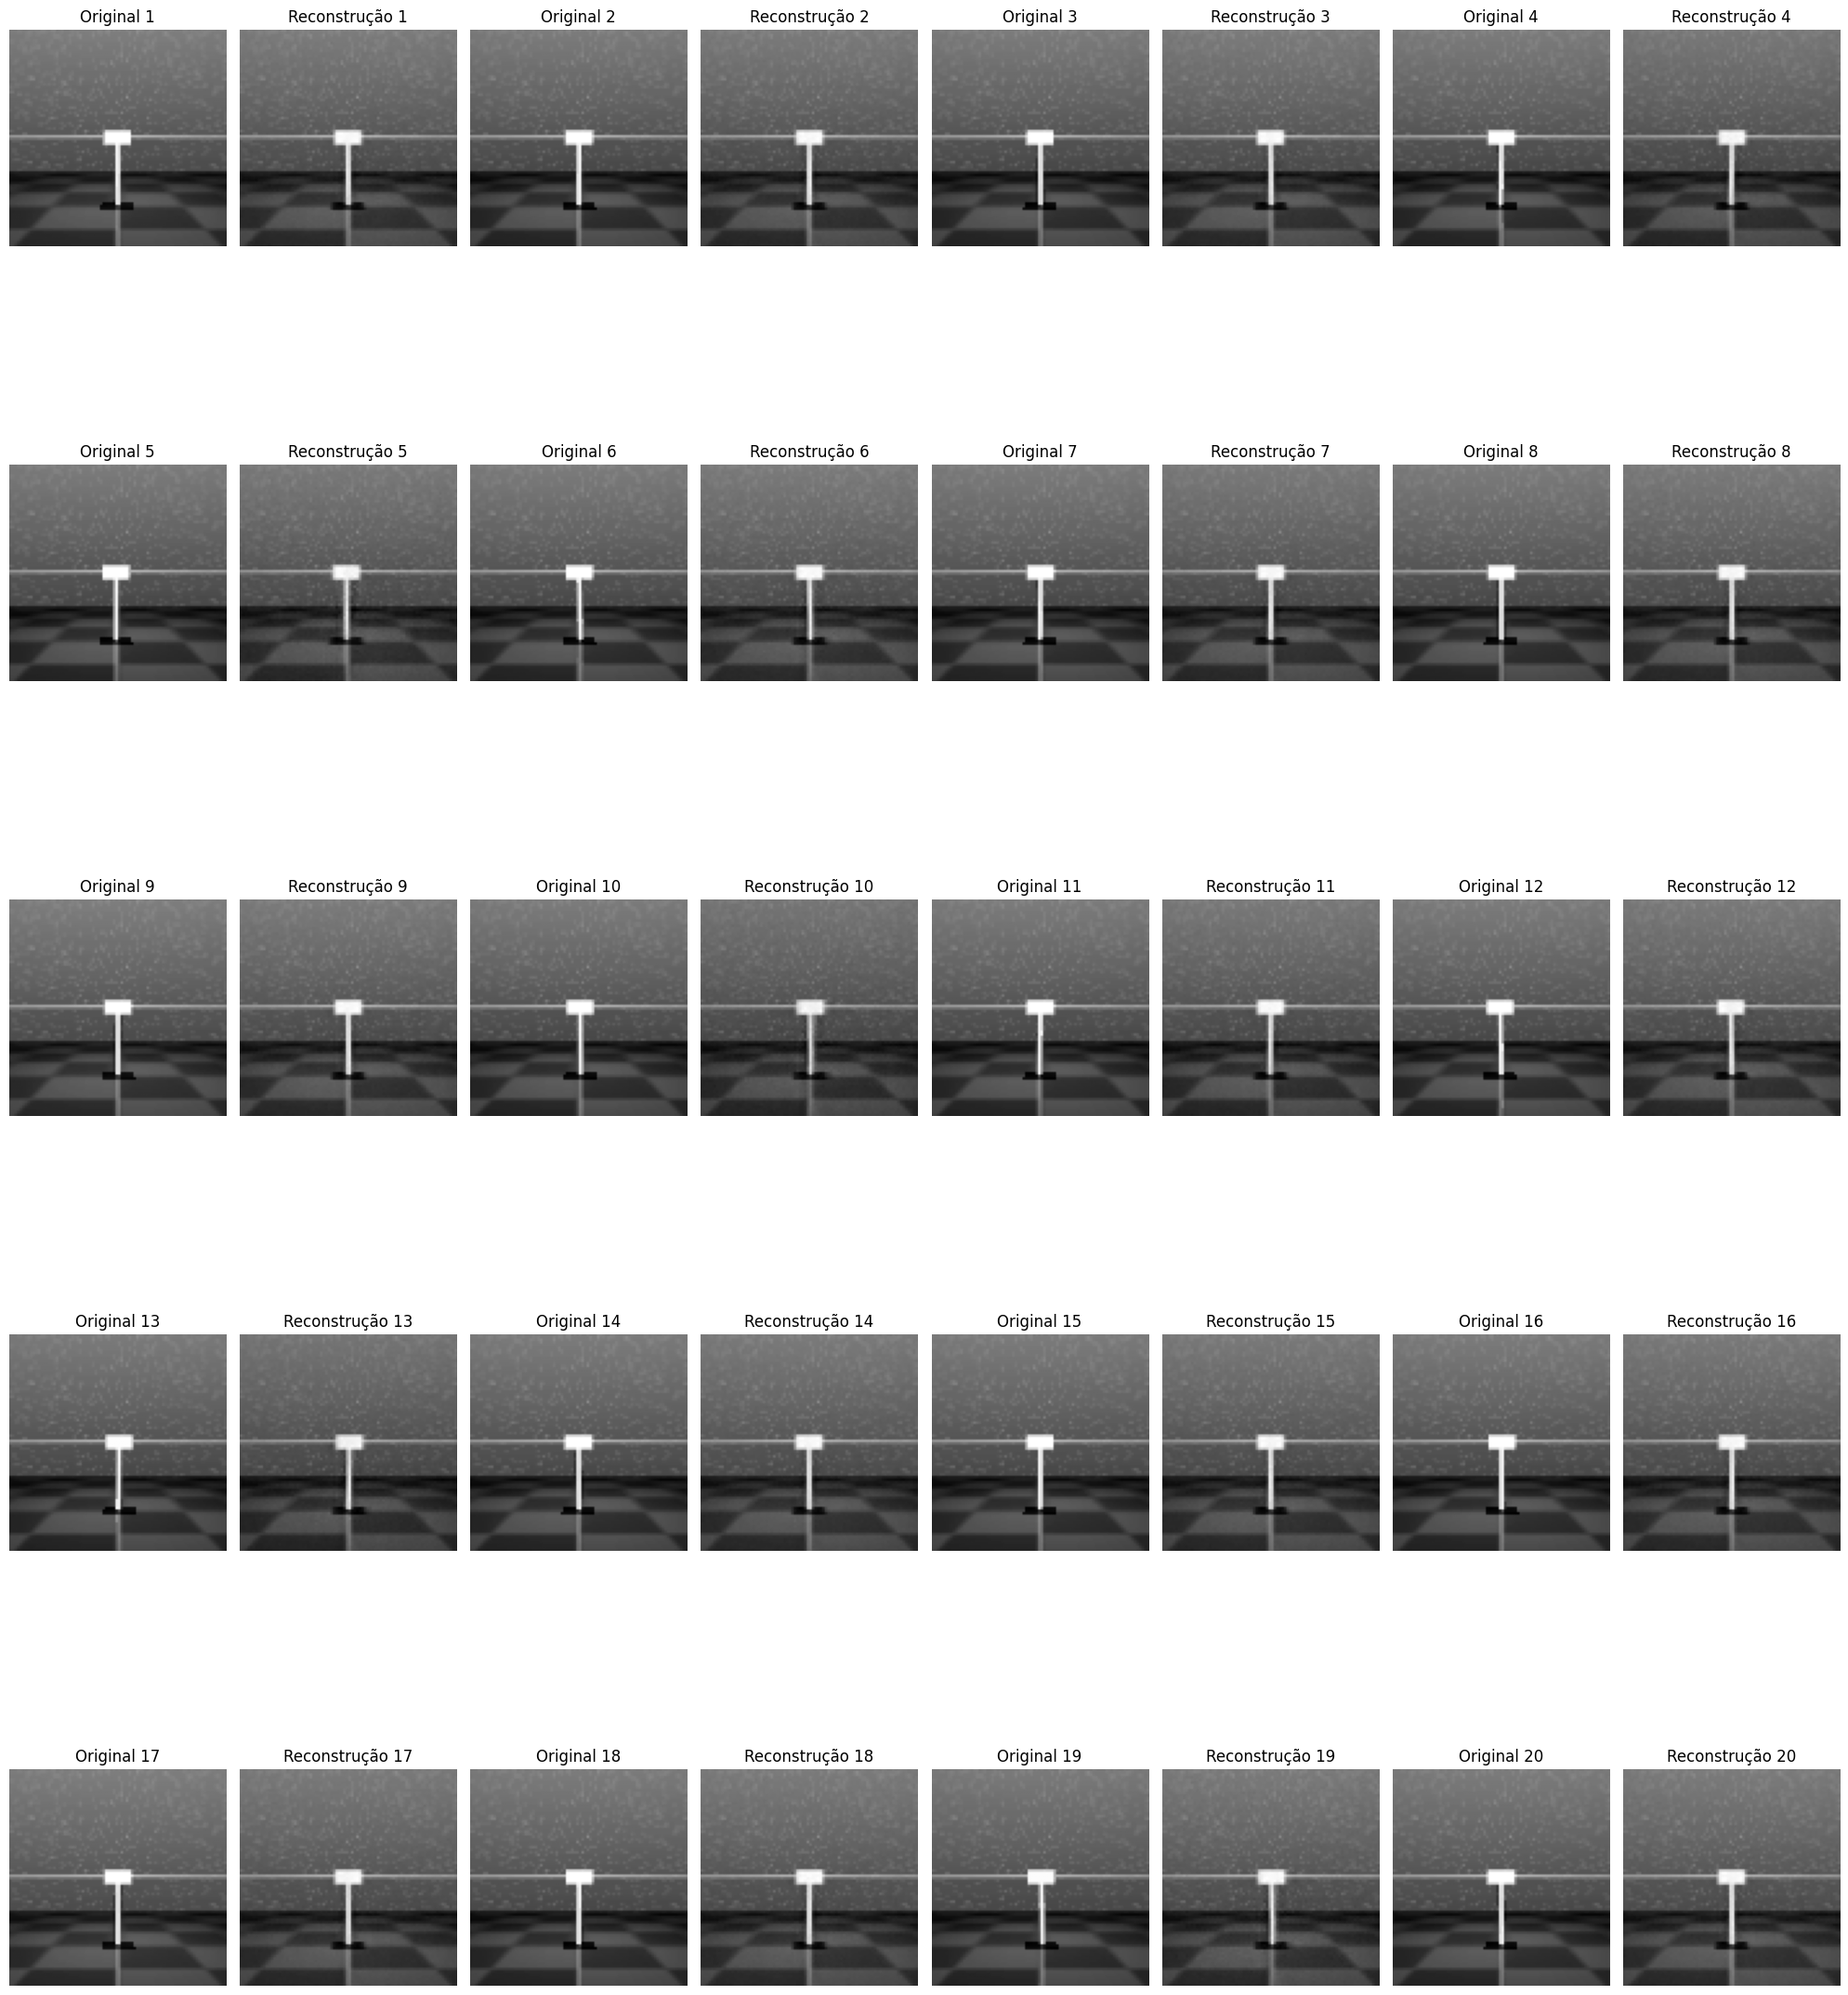

Visualizadas 20 reconstruções


In [5]:
def visualize_vae_reconstructions(model, env, num_samples=20):
    """
    Gera e mostra reconstruções do VAE diretamente na tela
    
    Args:
        model: Modelo VAE treinado
        env: Ambiente DM Control
        num_samples: Número de amostras a visualizar
    """
    model.eval()
    
    # Configura o layout de visualização
    n_cols = 4  # Número de colunas no grid
    n_rows = (num_samples + n_cols - 1) // n_cols  # Calcula linhas necessárias
    plt.figure(figsize=(20, 5*n_rows))
    
    with torch.no_grad():
        for i in range(num_samples):
            # Coleta imagem do ambiente
            time_step = env.reset()
            original_img = converter_cinza(time_step.observation['pixels'])
            
            # Pré-processamento idêntico ao treinamento
            processed_img = original_img.astype(np.float32) / 127.5 - 1.0
            tensor_img = torch.tensor(processed_img, device=device, 
                                    dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            
            # Reconstrução
            recon_img, _, _ = model(tensor_img)
            
            # Pós-processamento
            original_img = original_img / 255.0  # [0, 1]
            recon_img = recon_img.squeeze().cpu().numpy()
            
            # Plota as imagens em um grid
            plt.subplot(n_rows, n_cols*2, 2*i+1)
            plt.imshow(original_img, cmap='gray')
            plt.title(f"Original {i+1}")
            plt.axis("off")
            
            plt.subplot(n_rows, n_cols*2, 2*i+2)
            plt.imshow(recon_img, cmap='gray')
            plt.title(f"Reconstrução {i+1}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    print(f"Visualizadas {num_samples} reconstruções")

# Uso:
env_test = suite.load(domain_name="cartpole", task_name="swingup")
env_test = pixels.Wrapper(env_test, pixels_only=True,
                    render_kwargs={'height': 84, 'width': 84, 'camera_id': 0})

visualize_vae_reconstructions(model, env_test, num_samples=20)

Create two environments - for training and testing

In [6]:
env_train = suite.load(domain_name="cartpole", task_name="swingup")
env_train = pixels.Wrapper(env_train, pixels_only=True,
                    render_kwargs={'height': 84, 'width': 84, 'camera_id': 0})
# Teste com imagens do ambiente
env_test = suite.load(domain_name="cartpole", task_name="swingup")
env_test = pixels.Wrapper(env_train, pixels_only=True,
                    render_kwargs={'height': 84, 'width': 84, 'camera_id': 0})

action_spec = env_test.action_spec()
obs_spec = env_test.observation_spec()
reward_spec = env_test.reward_spec()
print(action_spec, obs_spec,reward_spec)

BoundedArray(shape=(1,), dtype=dtype('float64'), name=None, minimum=[-1.], maximum=[1.]) OrderedDict([('pixels', Array(shape=(84, 84, 3), dtype=dtype('uint8'), name='pixels'))]) Array(shape=(), dtype=dtype('float64'), name='reward')


Create the backbone network

Define the actor-critic model

In [ ]:
class Critic(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        #x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        #x = self.dropout(x)
        x = self.layer3(x)  
        return x

class Actor(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim, num_layers=2, init_std=0.1, min_std=0.01):
        super().__init__()
        self.layers = nn.ModuleList()
        self.action_dim = action_dim
        
        # Camadas ocultas
        for i in range(num_layers):
            in_size = input_dim if i == 0 else hidden_dim
            self.layers.append(nn.Linear(in_size, hidden_dim))
        
        # Camada de saída para média e desvio padrão
        self.mean_layer = nn.Linear(hidden_dim, action_dim)
        self.log_std_layer = nn.Linear(hidden_dim, action_dim)
        
        # Parâmetros para o desvio padrão
        self.min_std = min_std
        self.log_std_layer.weight.data.fill_(0.0) #TODO: por que fazer isso?
        self.log_std_layer.bias.data.fill_(np.log(np.exp(init_std) - 1))  # Softplus inverso

    def forward(self, x):
        # Passagem pelas camadas ocultas
        for layer in self.layers:
            x = f.relu(layer(x))
        
        # Calcula média e desvio padrão
        mean = torch.tanh(self.mean_layer(x))  # [-1, 1]
        log_std = self.log_std_layer(x)
        std = f.softplus(log_std) + self.min_std  # Sempre positivo
        
        # Cria distribuição com transformação tanh
        base_dist = Normal(mean, std)
        transforms = TanhTransform()
        dist = TransformedDistribution(base_dist, transforms)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        
        return action, log_prob_action, dist

In [1]:

# Configurações
input_dim = 128  # Dimensão do estado
hidden_dim = 256
action_dim = 3    # Dimensão da ação (ex: 3 ações contínuas)

# Cria modelo
model = Actor(input_dim, hidden_dim, action_dim).to(device)

# Estado de exemplo
state = torch.randn(1, input_dim).to(device)  # Batch size 1

# Obtém distribuição de ações
action, log_prob_action, dist = model(state)

print(action, log_prob_action, dist)  # Valores entre -1 e 1

# Calcula log prob de uma ação específica
test_action = torch.tensor([0.5, -0.2, 0.8], device=device).unsqueeze(0)
log_prob = dist.log_prob(test_action)
print("Log probabilidade:", log_prob)

NameError: name 'Actor' is not defined

Create an agent

In [9]:
def create_agent(HIDDEN_DIMENSIONS, DROPOUT, INPUT_FEATURES, ACTOR_OUTPUT_FEATURES):
    CRITIC_OUTPUT_FEATURES = 1

    actor = Actor(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES).to(device)
    critic = Critic(
            INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT).to(device)
    return actor, critic


Define a function to calculate the returns from the rewards

In [10]:
def calculate_returns(rewards, discount_factor):
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)

    returns = torch.tensor(returns)
    # normalize the return
    returns = (returns - returns.mean()) / returns.std()

    return returns


Define a function to calculate the advantages

In [11]:
def calculate_advantages(returns, values):
    advantages = returns - values
    # Normalize the advantage
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages


Define a function to calculate surrogate losses

In [12]:
def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss


Define a function to calculate policy loss and value loss

In [13]:
def calculate_losses(
        surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    #entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss).sum() #-(surrogate_loss + entropy_bonus).sum()
    value_loss = f.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss


Initialize a set of buffers to use during the training

In [14]:
def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward


Define the forward pass

In [15]:
def forward_pass(env, actor, critic, encoder, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    time_step = env.reset()

    # Processamento do estado inicial com float32
    state = converter_cinza(time_step.observation['pixels'])
    state = state.astype(np.float32) / 127.5 - 1.0  # Já garante float32
    state = torch.tensor(state, dtype=torch.float32).to(device)
    state = state.unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        z_mean, z_log_var = encoder(state)

    state = reparameterize(z_mean, z_log_var).detach()

    actor.train()
    critic.train()
    while not done:
        states.append(state.detach())
        
        # Garante float32 nas saídas para trabalhar com mac
        action, log_prob_action, _ = actor(state.detach())
        value_pred = critic(state).float() 
        
        time_step = env.step(action.item())
        done = time_step.last()
        reward = time_step.reward if time_step.reward is not None else 0.0
        
        # Processamento do novo estado
        state = converter_cinza(time_step.observation['pixels'])
        state = state.astype(np.float32) / 127.5 - 1.0
        state = torch.tensor(state, dtype=torch.float32).to(device)
        state = state.unsqueeze(0).unsqueeze(0) #TODO testar sem unsqueeze
        
        with torch.no_grad():
            z_mean, z_log_var = encoder(state)
        state = reparameterize(z_mean, z_log_var)

        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(float(reward))  # Garante Python float
        episode_reward += reward

    # Concatenação com float32
    states = torch.cat(states).to(device)
    actions = torch.cat(actions).to(device)
    actions_log_probability = torch.cat(actions_log_probability).to(device)
    values = torch.cat(values).squeeze(-1).to(device)
    
    # Modificação crítica: Garante float32 nos retornos
    returns = calculate_returns(rewards, discount_factor).float().to(device)  # <-- Correção aqui
    advantages = calculate_advantages(returns, values).float().to(device)

    return episode_reward, states, actions, actions_log_probability, advantages, returns

Define the function to update the policy parameters

In [16]:
def update_policy(
        actor,
        critic,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer_actor,
        optimizer_critic,
        ppo_steps,
        epsilon,
        entropy_coefficient):

    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0
    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()

    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)

    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)

    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            # get new log prob of actions for all input states
            action, actions_log_probability_new, probability_distribution_new = actor(states) 
            value_pred = critic(states)
            value_pred = value_pred.squeeze(-1)
            #entropy = probability_distribution_new.entropy() #TODO implementar entropia
            entropy = 0

            # estimate new log probabilities using old actions
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            policy_loss, value_loss = calculate_losses(
                    surrogate_loss,
                    entropy,
                    entropy_coefficient,
                    returns,
                    value_pred)

            optimizer_actor.zero_grad() 
            policy_loss.backward()
            optimizer_actor.step()

            optimizer_critic.zero_grad()
            value_loss.backward()
            optimizer_critic.step()
            # calculate the total loss
            # and add it to the total loss
            # for the current batch

            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()

    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps


Define a function to evaluate the model's (policy's) performance

In [17]:
def evaluate(env, actor, encoder, device):
    actor.eval()
    
    time_step = env.reset()
    episode_reward = 0
    done = False
    
    # Processamento inicial do estado
    state = converter_cinza(time_step.observation['pixels'])
    state = state.astype(np.float32) / 127.5 - 1.0
    state = torch.tensor(state).float().to(device)  # Convertido para float e movido para o device
    state = state.unsqueeze(0).unsqueeze(0)
    
    with torch.no_grad():
        z_mean, z_log_var = encoder(state)
    state = reparameterize(z_mean, z_log_var).detach()

    while not done:
        with torch.no_grad():
            action, log_prob_action, dist = actor(state)

        time_step = env.step(action.item())
        done = time_step.last()
        reward = time_step.reward if time_step.reward is not None else 0.0
        
        # Processamento do novo estado
        state = converter_cinza(time_step.observation['pixels'])
        state = state.astype(np.float32) / 127.5 - 1.0
        state = torch.tensor(state).float().to(device)  # Convertido para float e movido para o device
        state = state.unsqueeze(0).unsqueeze(0)
        
        with torch.no_grad():
            z_mean, z_log_var = encoder(state)
        state = reparameterize(z_mean, z_log_var).detach()
        
        episode_reward += reward

    return episode_reward

Define a function to plot the rewards

In [18]:
def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label='Train Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [19]:
def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label='Test Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


Define a function to plot the losses

In [20]:
def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


Define the main function to train and evaluate the model

In [21]:
def run_ppo(): #TODO: random search de parametros
    print(encoder)
    device =  training_device()
    use_wandb = True
    name_wandb = "teste1"
    LATENT_DIM = 128
    IN_CHANNELS = 1
    HIDDEN_UNITS = 128
    INPUT_FEATURES = LATENT_DIM
    ACTOR_OUTPUT_FEATURES =  env_test.action_spec().shape[0]
    MAX_EPISODES = 1000
    DISCOUNT_FACTOR = 0.99
    REWARD_THRESHOLD = 500
    PRINT_INTERVAL = 1 #TODO
    PPO_STEPS = 10
    N_TRIALS = 100
    EPSILON = 0.2
    ENTROPY_COEFFICIENT = 0.01

    HIDDEN_DIMENSIONS = 350
    DROPOUT = 0.2
    LEARNING_RATE_ACTOR = 1e-8
    LEARNING_RATE_CRITIC = 1e-8

    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []

    actor, critic = create_agent(HIDDEN_DIMENSIONS, DROPOUT, INPUT_FEATURES, ACTOR_OUTPUT_FEATURES)
    optimizer_actor = optim.Adam(actor.parameters(), lr=LEARNING_RATE_ACTOR)
    optimizer_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE_CRITIC)

    if use_wandb:
        wandb.init(project="ppo_dreamer", name= name_wandb, config={
            "LATENT_DIM": LATENT_DIM,
            "IN_CHANNELS": IN_CHANNELS,
            "HIDDEN_UNITS": HIDDEN_UNITS,
            "INPUT_FEATURES": INPUT_FEATURES,
            "ACTOR_OUTPUT_FEATURES": ACTOR_OUTPUT_FEATURES,
            "MAX_EPISODES": MAX_EPISODES,
            "DISCOUNT_FACTOR": DISCOUNT_FACTOR,
            "REWARD_THRESHOLD": REWARD_THRESHOLD,
            "PRINT_INTERVAL": PRINT_INTERVAL,
            "PPO_STEPS": PPO_STEPS,
            "N_TRIALS": N_TRIALS,
            "EPSILON": EPSILON,
            "ENTROPY_COEFFICIENT": ENTROPY_COEFFICIENT,
            "HIDDEN_DIMENSIONS": HIDDEN_DIMENSIONS,
            "DROPOUT": DROPOUT,
            "LEARNING_RATE_ACTOR": LEARNING_RATE_ACTOR,
            "LEARNING_RATE_CRITIC": LEARNING_RATE_CRITIC
        })

    for episode in range(1, MAX_EPISODES+1):
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
                env_train,
                actor,
                critic,
                encoder,
                DISCOUNT_FACTOR)
        policy_loss, value_loss = update_policy(
                actor,
                critic,
                states,
                actions,
                actions_log_probability,
                advantages,
                returns,
                optimizer_actor,
                optimizer_critic,
                PPO_STEPS,
                EPSILON,
                ENTROPY_COEFFICIENT)
        test_reward = evaluate(env_test, actor, encoder, device)

        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)

        mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        mean_abs_policy_loss = np.mean(policy_losses[-N_TRIALS:])
        mean_abs_value_loss = np.mean(value_losses[-N_TRIALS:])

        wandb.log({
            "episode": episode,
            "policy_loss": policy_loss,
            "value_loss": value_loss,
            "train_rewards": train_reward,
            "test_rewards": test_reward,
            "mean_train_rewards": mean_train_rewards,
            "mean_test_rewards": mean_test_rewards,
            "mean_abs_policy_loss": mean_abs_policy_loss,
            "mean_abs_value_loss": mean_abs_value_loss
        })

        if episode % PRINT_INTERVAL == 0:
            print(f'Episode: {episode:3d} | Training Reward: {train_reward:.1f} | '
                  f'Testing Reward: {test_reward:.1f} | '
                  f'Mean Train Rewards: {mean_train_rewards:.1f} | '
                  f'Mean Test Rewards: {mean_test_rewards:.1f} | '
                  f'Mean  Policy Loss: {mean_abs_policy_loss:.2f} | '
                  f'Mean  Value Loss: {mean_abs_value_loss:.2f} | '
                  f' Policy Loss: {policy_loss:.2f} | '
                  f'Value Loss: {value_loss:.2f} | ')

    plot_train_rewards(train_rewards, REWARD_THRESHOLD)
    plot_test_rewards(test_rewards, REWARD_THRESHOLD)
    plot_losses(policy_losses, value_losses)  


Run the main function

In [ ]:
run_ppo() 

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


CNNEncoder(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mean): Linear(in_features=51200, out_features=128, bias=True)
  (fc_log_var): Linear(in_features=51200, out_features=128, bias=True)
)
mps


wandb: Currently logged in as: marcospaulo2 (marcospaulo2-federal-university-of-goi-s) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


/opt/anaconda3/envs/ppo/lib/python3.10/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa


Episode:   1 | Training Reward: 10.5 | Testing Reward: 11.8 | Mean Train Rewards: 10.5 | Mean Test Rewards: 11.8 | Mean  Policy Loss: -3073.91 | Mean  Value Loss: 3.92 |  Policy Loss: -3073.91 | Value Loss: 3.92 | 
Episode:   2 | Training Reward: 14.8 | Testing Reward: 7.8 | Mean Train Rewards: 12.6 | Mean Test Rewards: 9.8 | Mean  Policy Loss: -2861.31 | Mean  Value Loss: 3.89 |  Policy Loss: -2648.70 | Value Loss: 3.87 | 
Episode:   3 | Training Reward: 13.3 | Testing Reward: 7.0 | Mean Train Rewards: 12.9 | Mean Test Rewards: 8.9 | Mean  Policy Loss: -2820.27 | Mean  Value Loss: 3.88 |  Policy Loss: -2738.19 | Value Loss: 3.86 | 
Episode:   4 | Training Reward: 7.2 | Testing Reward: 9.1 | Mean Train Rewards: 11.4 | Mean Test Rewards: 8.9 | Mean  Policy Loss: -2906.75 | Mean  Value Loss: 3.84 |  Policy Loss: -3166.18 | Value Loss: 3.71 | 
Episode:   5 | Training Reward: 10.8 | Testing Reward: 21.7 | Mean Train Rewards: 11.3 | Mean Test Rewards: 11.5 | Mean  Policy Loss: -2645.25 | Me

KeyboardInterrupt: 

: 